# libraries

In [ ]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Absolute path to your key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal-key.json"

# Initialize BigQuery client
client = bigquery.Client()

In [2]:
table_id = f"{client.project}.garmin_data.garmin_raw_data"
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
df

/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal_env/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,filename,raw_json
0,body_battery_2025-09-22.json,"[{""date"": ""2025-09-22"", ""charged"": 45, ""draine..."
1,heart_rate_2025-04-17.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
2,body_battery_2025-05-01.json,"[{""date"": ""2025-05-01"", ""charged"": 36, ""draine..."
3,sleep_2025-04-15.json,"{""dailySleepDTO"": {""id"": 1744676720000, ""userP..."
4,sleep_2025-06-28.json,"{""dailySleepDTO"": {""id"": 1751058151000, ""userP..."
...,...,...
4540,steps_2025-09-19.json,"[{""startGMT"": ""2025-09-18T15:00:00.0"", ""endGMT..."
4541,steps_2025-07-07.json,"[{""startGMT"": ""2025-07-06T22:00:00.0"", ""endGMT..."
4542,stress_2025-09-12.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
4543,stress_2025-06-21.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."


In [3]:
import json
import pandas as pd

# Identify the type of JSON structure
def detect_json_type(raw):
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return 'list'
        elif isinstance(obj, dict):
            return 'dict'
        else:
            return 'other'
    except Exception:
        return 'invalid'

df['json_type'] = df['raw_json'].apply(detect_json_type)

# See how many of each type we have
print(df['json_type'].value_counts())

# Peek at unique filename prefixes (the metric types)
df['metric'] = df['filename'].str.extract(r'^([^_]+)')
print(df['metric'].value_counts())


json_type
dict    2730
list    1815
Name: count, dtype: int64
metric
body      910
heart     910
sleep     910
stress    910
steps     905
Name: count, dtype: int64


In [ ]:
# Copy the original dataframe
df_clean = df.copy()

# Function to normalize JSON
def normalize_json(x):
    if isinstance(x, str):
        x = json.loads(x)  # parse JSON string
    if isinstance(x, list):
        return pd.DataFrame(x)  # explode list of dicts
    elif isinstance(x, dict):
        return pd.DataFrame([x])  # wrap dict in a DataFrame
    else:
        return pd.DataFrame()  # empty fallback

# Create a dictionary to hold separate tidy dfs by filename prefix
tidy_dfs = {}

# Loop through unique filename prefixes (everything before the first '_')
for prefix in df_clean['filename'].str.split('_').str[0].unique():
    df_subset = df_clean[df_clean['filename'].str.startswith(prefix)]
    temp_list = []
    
    for _, row in df_subset.iterrows():
        temp_df = normalize_json(row['raw_json'])
        if not temp_df.empty:
            temp_df['filename'] = row['filename']  # keep filename
            temp_list.append(temp_df)
    
    if temp_list:
        tidy_dfs[prefix] = pd.concat(temp_list, ignore_index=True)

# Now tidy_dfs contains:
# keys: 'body', 'heart', 'sleep', 'stress', 'steps'
# values: the corresponding tidy DataFrames
# Example: inspect the first few rows of body_battery
tidy_dfs.keys()


dict_keys(['body', 'heart', 'sleep', 'stress', 'steps'])

# body battery

In [7]:

def get_all_column_names(dataframes: dict) -> None:
    """
    Iterates through a dictionary of DataFrames and prints the column names 
    for each one, displayed as a single, comma-separated list.
    
    Args:
        dataframes: A dictionary where keys are dataset names (str) and values 
                    are pandas DataFrames.
    """
    print("-" * 50)
    print("Dataset Column Inspection")
    print("-" * 50)

    for name, df in dataframes.items():
        # Using f-strings to format the output nicely
        print(f"\n[{name.upper()} Dataset ({len(df)} rows)]")
        
        # Check if the object is actually a DataFrame before getting columns
        if isinstance(df, pd.DataFrame):
            columns = df.columns.tolist()
            # Join all column names into a single comma-separated string for easy viewing
            print("Columns (List):")
            print(f"  {', '.join(columns)}")
        else:
            print("Warning: Item is not a pandas DataFrame.")


# Execute the function
get_all_column_names(tidy_dfs)


--------------------------------------------------
Dataset Column Inspection
--------------------------------------------------

[BODY Dataset (910 rows)]
Columns (List):
  date, charged, drained, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, bodyBatteryValuesArray, bodyBatteryValueDescriptorDTOList, bodyBatteryDynamicFeedbackEvent, bodyBatteryActivityEvent, filename, endOfDayBodyBatteryDynamicFeedbackEvent

[HEART Dataset (910 rows)]
Columns (List):
  userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxHeartRate, minHeartRate, restingHeartRate, lastSevenDaysAvgRestingHeartRate, heartRateValueDescriptors, heartRateValues, filename

[SLEEP Dataset (910 rows)]
Columns (List):
  dailySleepDTO, sleepMovement, remSleepData, sleepLevels, sleepRestlessMoments, restlessMomentsCount, wellnessEpochRespirationDataDTOList, wellnessEpochRespirationAveragesList, respirationVersion, sleepHeartRate, sleepStress, slee

# merging dfs

In [ ]:
# NOTE: This script assumes 'tidy_dfs' (the dictionary of your raw DataFrames 
# from 'body', 'heart', 'sleep', 'stress', and 'steps') is already loaded 
# into your current environment.

# --------------------------------------------------------------------------
# Data Engineering Functions
# --------------------------------------------------------------------------

def clean_and_aggregate_data(tidy_dfs: dict) -> dict:
    """
    Selects meaningful columns, including complex array/object columns, 
    renames them, and performs basic type-conversion for numeric fields.
    """
    cleaned_dfs = {}

    # 1. BODY Data (Daily)
    body_df = tidy_dfs['body'].copy()
    body_cols = [
        'date', 'charged', 'drained', 'bodyBatteryValuesArray', 
        'bodyBatteryValueDescriptorDTOList', 'bodyBatteryDynamicFeedbackEvent'
    ]
    # Select only columns that exist in the DataFrame
    body_df = body_df[[col for col in body_cols if col in body_df.columns]].copy()
    
    # Clean up types
    body_df['date'] = pd.to_datetime(body_df['date']).dt.normalize()
    for col in ['charged', 'drained']:
        if col in body_df.columns:
            body_df[col] = pd.to_numeric(body_df[col], errors='coerce')

    cleaned_dfs['body'] = body_df.rename(columns={
        'charged': 'body_charged', 
        'drained': 'body_drained', 
        'bodyBatteryValuesArray': 'body_battery_values',
        'bodyBatteryValueDescriptorDTOList': 'body_battery_descriptors',
        'bodyBatteryDynamicFeedbackEvent': 'body_dynamic_feedback'
    })

    # 2. HEART Data (Daily)
    heart_df = tidy_dfs['heart'].copy()
    heart_cols = [
        'calendarDate', 'restingHeartRate', 'maxHeartRate', 'minHeartRate', 
        'heartRateValues'
    ]
    heart_df = heart_df[[col for col in heart_cols if col in heart_df.columns]].copy()
    
    # Clean up types
    heart_df['calendarDate'] = pd.to_datetime(heart_df['calendarDate'])
    for col in ['restingHeartRate', 'maxHeartRate', 'minHeartRate']:
        if col in heart_df.columns:
            heart_df[col] = pd.to_numeric(heart_df[col], errors='coerce')
    
    cleaned_dfs['heart'] = heart_df.rename(columns={
        'calendarDate': 'date', 
        'restingHeartRate': 'heart_resting_hr',
        'maxHeartRate': 'heart_max_hr', 
        'minHeartRate': 'heart_min_hr',
        'heartRateValues': 'heart_rate_values'
    })

    # 3. STRESS Data (Daily)
    stress_df = tidy_dfs['stress'].copy()
    stress_cols = [
        'calendarDate', 'avgStressLevel', 'maxStressLevel', 
        'stressValuesArray', 'bodyBatteryValuesArray' # Keeping BB array here if it provides different values than the body file
    ]
    stress_df = stress_df[[col for col in stress_cols if col in stress_df.columns]].copy()
    
    # Clean up types
    stress_df['calendarDate'] = pd.to_datetime(stress_df['calendarDate'])
    for col in ['avgStressLevel', 'maxStressLevel']:
        if col in stress_df.columns:
            stress_df[col] = pd.to_numeric(stress_df[col], errors='coerce')
    
    cleaned_dfs['stress'] = stress_df.rename(columns={
        'calendarDate': 'date', 
        'avgStressLevel': 'stress_avg', 
        'maxStressLevel': 'stress_max',
        'stressValuesArray': 'stress_values',
        'bodyBatteryValuesArray': 'stress_body_battery_values'
    })

    # 4. SLEEP Data (Daily)
    sleep_df = tidy_dfs['sleep'].copy()
    date_col_name = 'date' if 'date' in sleep_df.columns else 'calendarDate'
    
    if date_col_name in sleep_df.columns:
        sleep_df[date_col_name] = pd.to_datetime(sleep_df[date_col_name]).dt.normalize()
        sleep_df.rename(columns={date_col_name: 'date'}, inplace=True)
    elif 'body' in cleaned_dfs:
        # Fallback for datasets without a clean date column (assuming alignment)
        sleep_df['date'] = cleaned_dfs['body']['date'].copy()
        
    sleep_cols_to_keep = [
        'date', 'restingHeartRate', 'avgOvernightHrv', 'restlessMomentsCount', 
        'sleepStress', 'sleepLevels', 'sleepMovement', 'remSleepData', 
        'sleepHeartRate', 'sleepBodyBattery', 'hrvData', 'breathingDisruptionData'
    ]
    
    valid_sleep_cols = [col for col in sleep_cols_to_keep if col in sleep_df.columns]
    sleep_df = sleep_df[valid_sleep_cols]
    
    # Convert appropriate columns to numeric
    for col in ['restingHeartRate', 'avgOvernightHrv', 'restlessMomentsCount', 'sleepStress']:
        if col in sleep_df.columns:
            sleep_df[col] = pd.to_numeric(sleep_df[col], errors='coerce')

    cleaned_dfs['sleep'] = sleep_df.rename(columns={
        'restingHeartRate': 'sleep_resting_hr', 
        'avgOvernightHrv': 'sleep_avg_hrv', 
        'restlessMomentsCount': 'sleep_restless_moments',
        'sleepStress': 'sleep_stress', 
        'sleepLevels': 'sleep_levels',
        'sleepMovement': 'sleep_movement',
        'remSleepData': 'sleep_rem_data',
        'sleepHeartRate': 'sleep_heart_rate',
        'sleepBodyBattery': 'sleep_body_battery',
        'hrvData': 'sleep_hrv_data',
        'breathingDisruptionData': 'sleep_breathing_disruption'
    })

    # 5. STEPS Data (Granular -> Daily Aggregation)
    steps_df = tidy_dfs['steps'].copy()
    steps_df['date'] = pd.to_datetime(steps_df['startGMT']).dt.date
    
    steps_daily = steps_df.groupby('date').agg(
        total_steps=('steps', 'sum'), total_pushes=('pushes', 'sum')
    ).reset_index()
    
    steps_daily['date'] = pd.to_datetime(steps_daily['date'])
    cleaned_dfs['steps'] = steps_daily.rename(columns={
        'total_steps': 'steps_total', 'total_pushes': 'steps_pushes'
    })
    return cleaned_dfs


def merge_cleaned_datasets(cleaned_dfs: dict) -> pd.DataFrame:
    """
    Performs an outer merge on the standardized 'date' column and ensures 
    uniqueness by aggregating all daily metrics into a single row per date.
    """
    if not cleaned_dfs:
        return pd.DataFrame()

    # Start with the first DataFrame
    master_df = cleaned_dfs['body'].copy()
    
    # Iterate through the rest and merge iteratively
    for name, df in cleaned_dfs.items():
        if name != 'body':
            master_df = pd.merge(master_df, df, on='date', how='outer', suffixes=('_body', f'_{name}'))

    # CRITICAL FIX: Group by date and aggregate to collapse multiple rows into one.
    agg_dict = {col: 'max' for col in master_df.columns if col != 'date'}
    
    # Identify non-numeric/object columns (like nested arrays/lists) that can't use 'max'
    # and use 'first' to select the first non-null value instead.
    for col in master_df.columns:
        if master_df[col].dtype == object and col != 'date':
            agg_dict[col] = 'first'
    
    # Apply the explicit aggregation
    master_df = master_df.groupby('date', dropna=False).agg(agg_dict).reset_index()
            
    # Sort by date for proper time-series analysis
    master_df = master_df.sort_values('date').reset_index(drop=True)
    return master_df


if __name__ == '__main__':
    # Assume 'tidy_dfs' is available in the execution environment
    try:
        if not isinstance(tidy_dfs, dict) or not tidy_dfs:
            raise NameError
    except NameError:
        print("Error: 'tidy_dfs' is not defined. Please ensure your data loading script has run.")
        exit()

    print("--- Running Comprehensive Data Preparation and Merge Pipeline ---")
    
    # 1. Clean and aggregate dataframes
    cleaned_data = clean_and_aggregate_data(tidy_dfs)
    
    # 2. Merge all daily dataframes
    analysis_ready_df = merge_cleaned_datasets(cleaned_data)
    
    # 3. Extract features from granular nested columns
    analysis_ready_df = extract_granular_features(analysis_ready_df)
    
    # We skip imputation and lagging for now to check the merged data first, as requested.
    
    print("\n--- Final Master DataFrame Details ---")
    print(f"Shape of Master DataFrame: {analysis_ready_df.shape}")
    print(f"Total Columns: {len(analysis_ready_df.columns)}")
    
    print("\nFirst 5 rows of the merged data (showing new granular features):")
    # Select columns to display: date, numeric summaries, and the new features
    display_cols = [
        'date', 'body_charged', 'body_drained', 'stress_avg', 
        'body_bb_mean', 'body_bb_std', 'heart_hr_mean', 'heart_hr_std', 
        'stress_lvl_mean', 'stress_lvl_count'
    ]
    
    # Only display columns that actually exist
    existing_display_cols = [col for col in display_cols if col in analysis_ready_df.columns]
    
    # FIX: Using .to_string() instead of .to_markdown() to avoid the 'tabulate' dependency error.
    print(analysis_ready_df[existing_display_cols].head(5).to_string(index=False))



--- Running Comprehensive Data Preparation and Merge Pipeline ---

--- Final Master DataFrame Details ---
Shape of Master DataFrame: (230, 39)
Total Columns: 39

First 5 rows of the merged data (showing new granular features):
      date  body_charged  body_drained  stress_avg  body_bb_mean  body_bb_std  heart_hr_mean  heart_hr_std  stress_lvl_mean  stress_lvl_count
2025-02-24           NaN           NaN         NaN           NaN          NaN            NaN           NaN              NaN                 0
2025-02-25           0.0          13.0        54.0     11.500000     6.500000      85.010638      8.139730        44.492188               128
2025-02-26          51.0          51.0        46.0     23.666667    19.963856      86.863889     14.098299        33.170833               480
2025-02-27          50.0          23.0        43.0     20.666667    10.609220      83.918803     10.052453        36.818750               480
2025-02-28          70.0          71.0        25.0     63.00000

# wrangling

In [56]:
df = analysis_ready_df.copy()

def expand_json_column(df, col_name, prefix):
    """
    Expand a JSON-like column that may contain:
      - dicts
      - lists of dicts
      - strings of JSON
      - None
    Returns a flattened DataFrame with prefixed column names.
    """
    expanded_rows = []

    for row in df[col_name]:
        # Try parsing strings
        if isinstance(row, str):
            try:
                row = json.loads(row)
            except json.JSONDecodeError:
                row = None

        # Case 1: dict -> wrap in list
        if isinstance(row, dict):
            expanded_rows.append(row)
        # Case 2: list of dicts -> flatten list
        elif isinstance(row, list):
            if len(row) > 0 and isinstance(row[0], dict):
                # Merge dicts if there are multiple (can also explode if you prefer)
                merged = {}
                for d in row:
                    merged.update(d)
                expanded_rows.append(merged)
            else:
                expanded_rows.append(None)
        else:
            expanded_rows.append(None)

    # Flatten the valid JSON-like rows
    expanded_df = pd.json_normalize(expanded_rows).add_prefix(prefix + "_")
    return expanded_df


# --- Expand your two nested columns ---
json_columns = ['body_battery_descriptors', 'body_dynamic_feedback']

for col in json_columns:
    expanded = expand_json_column(df, col, col)
    df = pd.concat([df.drop(columns=[col]), expanded], axis=1)


# --- Compute summary stats for numeric columns ---
numeric_cols = df.select_dtypes(include=[np.number]).columns

summary = pd.DataFrame({
    'missing_values': df[numeric_cols].isna().sum(),
    'mean': df[numeric_cols].mean(),
    'median': df[numeric_cols].median(),
    'min': df[numeric_cols].min(),
    'max': df[numeric_cols].max()
}).round(3)

# Display results
print("=== Summary of Numeric Columns ===")
display(summary)


=== Summary of Numeric Columns ===


,missing_values,mean,median,min,max
body_charged,7,54.493,57.000,0.000,92.000
body_drained,7,54.673,56.000,0.000,92.000
heart_resting_hr,9,60.529,60.000,54.000,75.000
heart_max_hr,9,134.928,132.000,102.000,193.000
heart_min_hr,9,57.222,57.000,40.000,83.000
stress_avg,9,41.339,41.000,17.000,78.000
stress_max,9,97.412,98.000,79.000,100.000
sleep_resting_hr,1,62.686,62.000,55.000,73.000
sleep_avg_hrv,3,41.590,42.000,23.000,54.000
sleep_restless_moments,1,42.175,42.000,22.000,70.000


# cleaning

In [73]:
# --- 1. Drop columns with ≥70% missing values ---
threshold = 0.7
df_cleaned = df.loc[:, df.isna().mean() < threshold]
print(f"Dropped columns: {set(df.columns) - set(df_cleaned.columns)}")

# --- 2. Fill missing values intelligently ---
df_filled = df_cleaned.copy()

cols_to_drop = [
    'stress_body_battery_values',
    'body_battery_descriptors_bodyBatteryValueDescriptorIndex',
    'body_battery_descriptors_bodyBatteryValueDescriptorKey',
    'body_dynamic_feedback_eventTimestampGmt',
    'body_dynamic_feedback_feedbackShortType',
    'body_dynamic_feedback_feedbackLongType'
    
]

df_filled = df_filled.drop(columns=cols_to_drop, errors='ignore')

# Numeric columns
for col in df_filled.select_dtypes(include=[np.number]).columns:
    # If time-like (e.g., HR, stress) → interpolate
    if any(keyword in col for keyword in ['hr', 'stress', 'body', 'sleep']):
        df_filled[col] = df_filled[col].interpolate(method='linear', limit_direction='both')
    else:
        # Otherwise, fill with median
        df_filled[col] = df_filled[col].fillna(df_filled[col].median())

# Categorical columns (if any remain)
for col in df_filled.select_dtypes(include=['object']).columns:
    df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')



Dropped columns: {'sleep_stress'}


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_1816/1694031855.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')
/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_1816/1694031855.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


# exploring the dataset

The problem: cause–effect is delayed


| Possible Relationship                                                | Lag Effect                  |
| -------------------------------------------------------------------- | --------------------------- |
| Poor sleep quality → lower body battery or higher stress             | **Next day (lag = +1)**     |
| High stress or high HR → worse sleep quality that night              | **Previous day (lag = –1)** |
| High physical activity → lower HRV or higher resting HR next morning | **Lag = +1**                |


## create lagged versions of key features

In [77]:
# Ensure chronological order
df_filled = df_filled.sort_values("date").reset_index(drop=True)

# Define features that evolve over time
lag_features = [
    'sleep_resting_hr', 'sleep_avg_hrv', 'sleep_restless_moments',
    'body_charged', 'body_drained',
    'stress_avg', 'stress_max'
]

# Create lagged versions (1-day lag)
for col in lag_features:
    df_filled[f"{col}_lag1"] = df_filled[col].shift(1)


# correlation

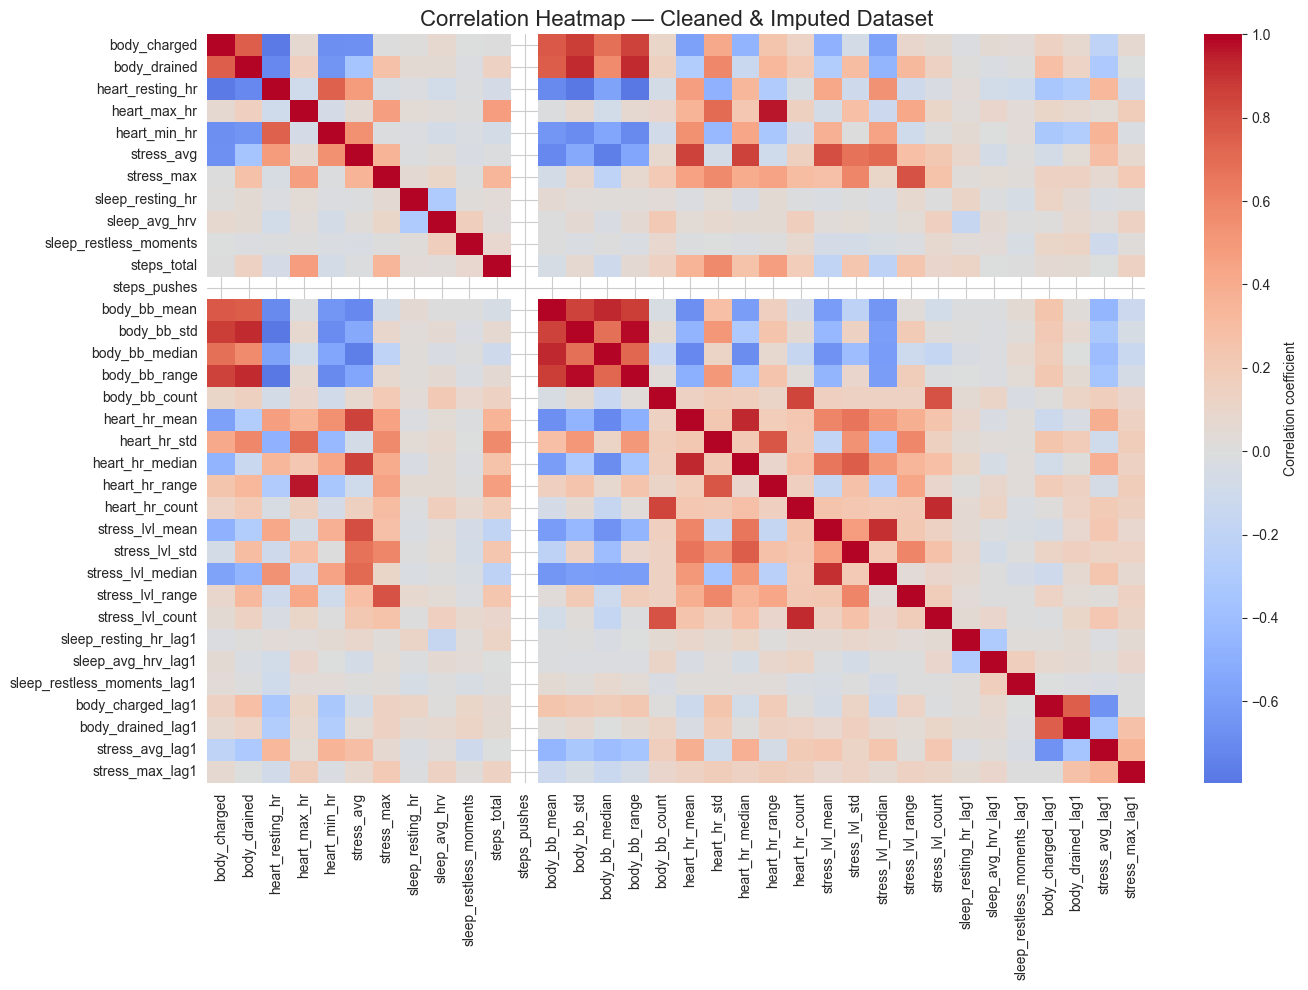

In [ ]:
# --- 3. Correlation matrix ---
corr = df_filled.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt='.2f',
    cbar_kws={'label': 'Correlation coefficient'}
)
plt.title('Correlation Heatmap — Cleaned & Imputed Dataset', fontsize=16)
plt.tight_layout()
plt.show()


In [82]:
# Compute correlation matrix
corr = df_filled.select_dtypes(include=[np.number]).corr()

# Take the upper triangle (to avoid duplicate pairs)
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find pairs with |correlation| > 0.8
strong_corrs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

strong_corrs = strong_corrs[strong_corrs['Correlation'].abs() > 0.8]\
    .sort_values(by='Correlation', ascending=False)

# Display results
if not strong_corrs.empty:
    print("🔍 Strong correlations (|r| > 0.7):")
    display(strong_corrs)
else:
    print("No correlations above 0.8 found.")


🔍 Strong correlations (|r| > 0.7):


,Feature_1,Feature_2,Correlation
319,body_bb_std,body_bb_range,0.983764
108,heart_max_hr,heart_hr_range,0.962679
393,heart_hr_mean,heart_hr_median,0.935970
298,body_bb_mean,body_bb_median,0.932649
42,body_drained,body_bb_std,0.929499
454,heart_hr_count,stress_lvl_count,0.928993
44,body_drained,body_bb_range,0.917093
463,stress_lvl_mean,stress_lvl_median,0.906147
11,body_charged,body_bb_std,0.869846
299,body_bb_mean,body_bb_range,0.868575


# ML/DL